# Lab Exercise #3 


In [513]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [514]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [515]:
# For easy modification
image_size = (128, 128)
batch_size = 32
epochs = 5

## Loading the Dataset

In [516]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

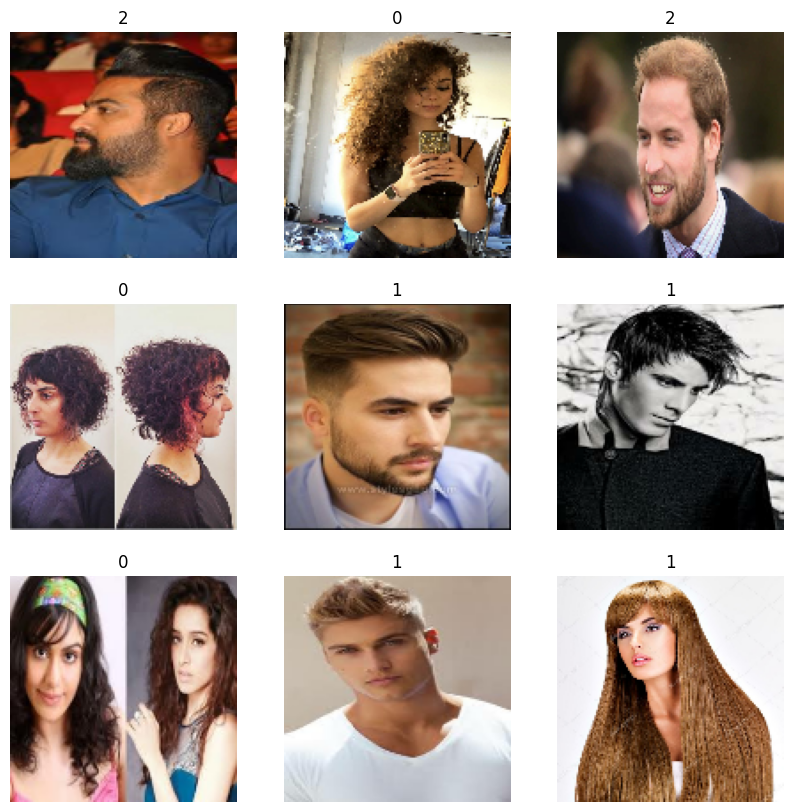

In [517]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Data Augmentation

In [518]:
import tensorflow as tf

def augment_data(image, label):
    #image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    #image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data)


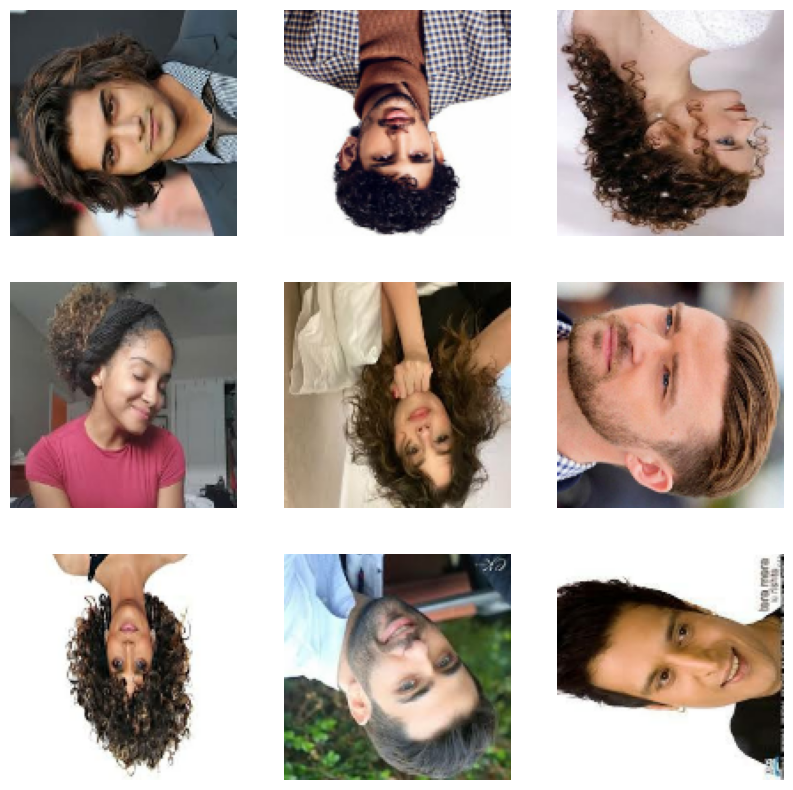

In [519]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()

## Model Architecture

In [520]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

# Define your model architecture
model = Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Rescaling(1.0 / 255),

    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    
    layers.Dense(units=256, activation="relu", kernel_regularizer=regularizers.l1_l2()), # 0.01 default
    DropConnect(rate=0.25),  # Applying DropConnect
    layers.Dense(3, activation="softmax")
])


# Freeze the layers up to the second last convolutional layer
for layer in model.layers[:-5]:
    layer.trainable = False

model.add(layers.Flatten())

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [521]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import layers

# # Load the pretrained VGG16 model without the top classification layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# # Freeze the pretrained layers
# base_model.trainable = False

# # Create a new model by adding your custom classification layers on top of the pretrained base
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     # Dropout(0.5),  # Adding dropout regularization
#     Dense(3, activation='softmax')
# ])

# # Compile the model with a lower learning rate

# model.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [522]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)


In [523]:
# Fine-tune the model
history = model.fit(augmented_train_ds, epochs=30, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4314 - loss: 1.1590 - val_accuracy: 0.3385 - val_loss: 1.1095 - learning_rate: 0.0100
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.4572 - loss: 1.1026 - val_accuracy: 0.2974 - val_loss: 1.1081 - learning_rate: 0.0100
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.5094 - loss: 1.0013 - val_accuracy: 0.3795 - val_loss: 1.0874 - learning_rate: 0.0100
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.5432 - loss: 0.9771 - val_accuracy: 0.3795 - val_loss: 1.0893 - learning_rate: 0.0100
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.4871 - loss: 1.0280 - val_accuracy: 0.3795 - val_loss: 1.0791 - learning_rate: 0.0100
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.4943 - loss: 1.0355 - val_accuracy: 0.2872 - val_loss: 1.1148 - learning_rate: 0.0100
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.5303 - loss: 0.9569 - 

## Model Evaluation

In [524]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
This image is 0.75 percent curly hair, 0.14 percent straight hair, and 0.11 percent wavy hair.


In [525]:
import os
import random

# Set the directory containing your dataset
dataset_dir = "hair_types/Curly_Hair/"

# Get a list of all files in the dataset directory
file_list = os.listdir(dataset_dir)

# Choose a random file from the list
random_file = random.choice(file_list)

# Construct the path to the randomly chosen image
image_path = os.path.join(dataset_dir, random_file)

# Load the image
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Print the results
print(
    "For the randomly chosen image (%s), the predicted percentages are: Curly Hair: %.2f%%, Straight Hair: %.2f%%, Wavy Hair: %.2f%%."
    % (random_file, predictions[0][0] * 100, predictions[0][1] * 100, predictions[0][2] * 100)
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
For the randomly chosen image (lede.jpg), the predicted percentages are: Curly Hair: 31.95%, Straight Hair: 35.98%, Wavy Hair: 32.07%.
